#### Importing required libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import convolve
from scipy import ndimage

#### Display function is defined for plotting images

In [2]:
def display(img,title): 
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    plt.title(title)
    plt.show()

#### A function for normalize. Thus images can be in the range of [0,1]

In [3]:
def normalize(image):
    image=image/np.max(image)
    return image

#### A function for convolution. We can slide the filter pixel by pixel

In [4]:
def convolve(image,kernel):
    copy_img=kernel
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            copy_img[i][j]=kernel[kernel.shape[0]-i-1][kernel.shape[1]-j-1]
    height=image.shape[0]
    width=image.shape[1]
    k_height=copy_img.shape[0]
    k_width=copy_img.shape[1]
    h = k_height//2
    w = k_width//2
    conved = image
    for i in range(h,height-h):
        for j in range(w,width-w):
            sum = 0
            for m in range(k_height):
                for n in range(k_width):
                    sum = sum + copy_img[m][n]*image[i-h+m][j-w+n]
            conved[i][j] = sum
    return conved

#### This function takes two paramaters that are kernel size and sigma. Kernel size depends on you. If you give a small kernel size, the blurring effect will be less. I'll use 5x5 kernel.
#### There is no exact formulation for the optimal sigma. I gave different values to see the effect on the image then I realized that as sigma value increases, the image becomes more blurred.

In [5]:
def gaussianFilter(k_size,sigma):
    x= int(k_size)//2
    y=int(k_size)//2
    g_arr=np.zeros((k_size, k_size), np.float32)
    for i in range(-x,x+1):
        for j in range(-y,y+1):
            norm=1/(2.0*np.pi*sigma*sigma)
            smt=np.exp(-(i**2 + j**2)/(2* sigma**2))
            g_arr[i+x,j+y]=norm*smt
    return g_arr

#### When we do Gradient Calculation, we can get the intensity and direction. We use the sobel filter matrixes. sx is for horizontal and sy is for vertical direction. These convolution kernels supply us to detect the points with change in light intensity. 

In [6]:
def sobel_filter(img,axis):
    if(axis == 'x'):
        sx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        filter = ndimage.convolve(img, sx)
    elif(axis == 'y'):
        sy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
        filter = ndimage.convolve(img, sy)
    norm_filter=normalize(filter)
    return norm_filter

In [7]:
def getGradient(img):
    Ix=sobel_filter(img,'x')
    Iy=sobel_filter(img,'y')
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    return G,theta

#### With nonMaxSupp function, we apply the Non-Maximum Suppression algorithm. With the help of this algortihm, we can get thiner edges. We find the local maximum. If the values are smaller than this value, then we will ignore them.

In [8]:
def nonMaxSupp(img,tetha):
    h,w = img.shape
    arr = np.zeros((h,w), dtype=np.int32)
    tetha[tetha < 0] += 180 
    for i in range(1,h-1):
        for j in range(1,w-1):
            q = 255
            r = 255
           #angle 0
            if (0 <= tetha[i,j] < 22.5) or (157.5 <= tetha[i,j] <= 180):
                q = img[i, j+1]
                r = img[i, j-1]
                
            #angle 45
            elif (22.5 <= tetha[i,j] < 67.5):
                q = img[i+1, j-1]
                r = img[i-1, j+1]
                
            #angle 90
            elif (67.5 <= tetha[i,j] < 112.5):
                q = img[i+1, j]
                r = img[i-1, j]
                
            #angle 135
            elif (112.5 <= tetha[i,j] < 157.5):
                q = img[i-1, j-1]
                r = img[i+1, j+1]

            if (img[i,j] >= q) and (img[i,j] >= r):
                arr[i,j] = img[i,j]
            
    return arr     

#### We cant get rid of all of the noises with non-max-supp. In this algorithm we determine a high and low threshold value to compare the pixel values.
#### If the pixel value is between high and low threshold, connectivity analysis.
#### If its under than the lowthreshold, no edges
#### If its higher than the highthreshold, actual edges.

In [9]:
def threshold(img):
    arr = np.zeros(img.shape, dtype=np.int32) 
    h,w = img.shape 
    lratio=0.05
    hratio=0.15
    htresh = img.max() * hratio
    lthresh = htresh * lratio
    for i in range(h - 1):
        for j in range(w - 1):
            intensity = img[i, j]
            if(intensity >= htresh): #higher than Threshold hight, strong edge!
                arr[i, j] = 255
            elif(htresh > intensity >= lthresh): #weak edge
                arr[i, j] = 75 #default to weak edge
                
    return arr

#### We do like connectivity analysis here.  It is like that:
#### If a weak edge doesn't connect with strong edge, then we will clean them


In [10]:
def hysteresis(img,low=75, high=255):
    h,w = img.shape  
    for i in range(1, h-1):
        for j in range(1, w-1):
            if (img[i,j] == low):
                try:
                    if ((img[i+1, j-1] == high) or (img[i+1, j] == high) or (img[i+1, j+1] == high)
                        or (img[i, j-1] == high) or (img[i, j+1] == high)
                        or (img[i-1, j-1] == high) or (img[i-1, j] == high) or (img[i-1, j+1] == high)):
                        img[i, j] = high
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

#### Loading image. But in this step when we read the image the color format is not the same with the original one. So I converted BGR to RGB  to see the original image.

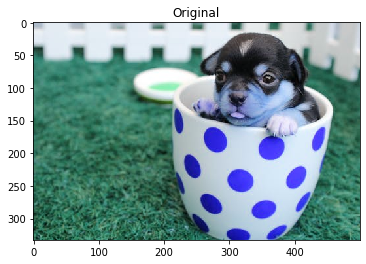

In [11]:
image=cv2.imread("dogcuk.jpeg")
display(image,'Original') #İmage is read in BGR format 
image = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #RGB format

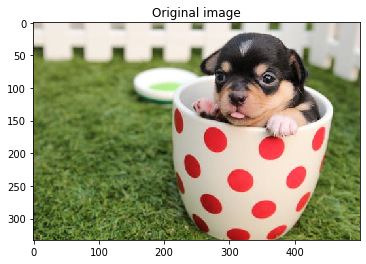

In [12]:
display(image,"Original image")

## Step1: Grayscale Conversion

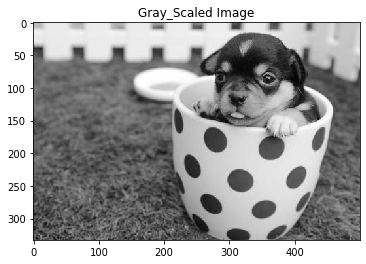

In [13]:
gray_one=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) # convert the color image to gray scale 
display(gray_one,"Gray_Scaled Image") # showing the gray scaled image on the screen via display func.

## Step-2: Gaussian Filter


In [14]:
gaussed_one=gaussianFilter(5,1)
gaussed_conved=convolve(gray_one,gaussed_one)

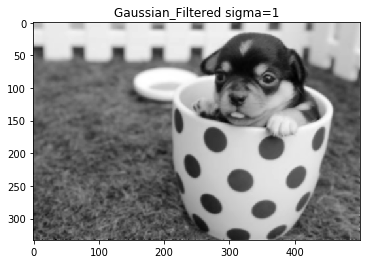

In [15]:
display(gaussed_conved,"Gaussian_Filtered sigma=1")

## Step-3: Finding Intensity Gradients of Image

In [16]:
G,Q=getGradient(normalize(gaussed_conved))

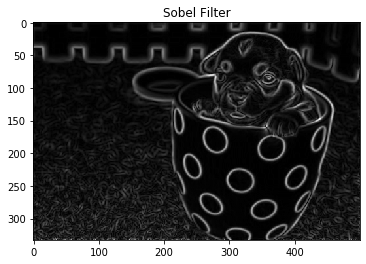

In [17]:
display(G,"Sobel Filter")

## Step-4: Non-Max. Supp.

In [18]:
Q = np.rad2deg(Q)  

In [19]:
supp_one=nonMaxSupp(G,Q)

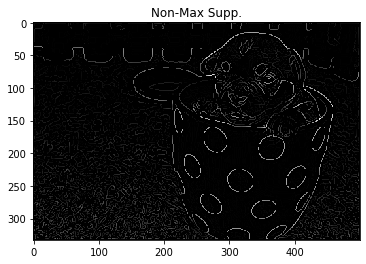

In [20]:
display(supp_one,"Non-Max Supp.")

## Step-5: Thresholding

In [21]:
thresh_img= threshold(supp_one) 

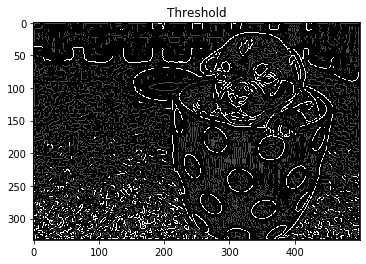

In [22]:
display(thresh_img,"Threshold")

## Step-6: Hysteresis

In [23]:
hyst_img = hysteresis(thresh_img)

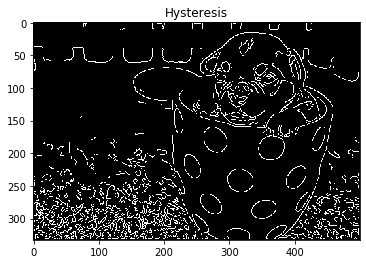

In [24]:
display(hyst_img,"Hysteresis")

# _Melinnur Kılıçarslan 161180041_ 
## CENG471 Assignment2